# CDEC: Unsupervised Clustering

In [6]:
from time import time
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics

from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np
import os 
from keras.preprocessing.image import load_img
import _pickle as cPickle
import _pickle 
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline
import gzip
import numpy as np
from PIL import Image
import matplotlib
import os
# For plotting graphs via ssh with no display
# Ref: https://stackoverflow.com/questions/2801882/generating-a-png-with-matplotlib-when-display-is-undefined
matplotlib.use('Agg')
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
from numpy import float32
from sklearn import metrics
from sklearn.cluster.k_means_ import KMeans
from sklearn import manifold
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn import preprocessing
from sklearn.utils import shuffle
from keras.layers import BatchNormalization

c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


## Convolutional DEC

### Step 1: convolutional auto encoder using `Conv2DTranspose`

In [258]:
def autoencoderConv2D_1(input_shape=(512, 512, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Convolutional auto encoder using `UpSampling2D`

In [10]:
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

def autoencoderConv2D_2(img_shape=(508, 508, 3)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (512, 512, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(4, kernel_initializer=init, activation='relu', name='encoded')(x)
    x = BatchNormalization()(encoded)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]), activation='relu', kernel_initializer=init)(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


### Pick a convolutional autoencoder (`autoencoderConv2D_1` or `autoencoderConv2D_2`)

In [11]:
autoencoder, encoder = autoencoderConv2D_2()

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 508, 508, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      73792     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
encoded (Dense)              (None, 4)                 524292    
__________

### Load breast biohistology images for convolutional input

In [262]:
def loadDataset():
    data= []
    labels =[]
    root ='/home/rkarim/Training_data/'

    for rootName,dirName,fileNames in os.walk(root):
        if(not rootName == root):
            for fileName in fileNames:
                imgGray = load_img(rootName+'/'+fileName,color_mode='rgb')
                if rootName.split('/')[1] == 'Benign':
                    labels+=[0]
                elif rootName.split('/')[1]== 'InSitu':
                    labels+=[1]
                elif rootName.split('/')[1]  == 'Invasive':
                    labels+=[2]
                else:
                    labels+=[3]
                  
                transformed=transform.resize(np.array(imgGray),(508,508))
                data += [transformed.reshape((transformed.shape[0],transformed.shape[1],3))]        
          
    data = np.stack(data)
    labels = np.stack(labels)
    #data,labels = shuffle(data,labels,random_state = 0)
    
    return [data,labels]

In [263]:
from keras.datasets import mnist

x, y =  loadDataset()
x.shape

#x = x.reshape(x.shape + (1,))
#x = np.divide(x, 255.)

(266, 508, 508, 3)

In [264]:
y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
     1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
     3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
     3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [265]:
y = np.array(y)

In [267]:
n_clusters = len(np.unique(y))
x.shape
n_clusters

4

### Pretrain covolutional autoencoder

In [289]:
pretrain_epochs = 1
batch_size = 128
save_dir = 'results/'

In [290]:
autoencoder.compile(optimizer='adam', loss='mse')

In [291]:
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/1
266/266 [==============================] - 248s 932ms/step - loss: 0.0619


In [292]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

### Build clustering model with convolutional autoencoder

In [293]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [294]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

### Step 1: initialize cluster centers using k-means

In [295]:
kmeans = KMeans(n_clusters=n_clusters, n_init=5)
y_pred_kmeans = kmeans.fit_predict(encoder.predict(x))

In [296]:
metrics.accuracy_score(y, y_pred_kmeans)

0.2819548872180451

In [297]:
y_pred_last = np.copy(y_pred_kmeans)

In [298]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering

In [299]:
#computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [300]:
loss = 0
index = 0
maxiter = 1000
update_interval = 10
index_array = np.arange(x.shape[0])

In [301]:
tol = 0.01 # tolerance threshold to stop training

### Start training

In [302]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.accuracy_score(y, y_pred), 5)
            nmi = np.round(metrics.mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

Iter 0: acc = 0.28195, nmi = 0.04127, ari = 0.01177  ; loss= 0
Iter 10: acc = 0.27820, nmi = 0.00000, ari = 0.00000  ; loss= 0.21101
Iter 20: acc = 0.27820, nmi = 0.00000, ari = 0.00000  ; loss= 0.0
delta_label  0.0 < tol  0.01
Reached tolerance threshold. Stopping training.


### Load the clustering model trained weights

In [303]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

### Final Evaluation

In [304]:
#Eval.

q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y, y_pred), 2)
    nmi = np.round(metrics.mutual_info_score(y, y_pred), 2)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 2)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.28000, nmi = 0.00000, ari = 0.00000  ; loss= 0.0


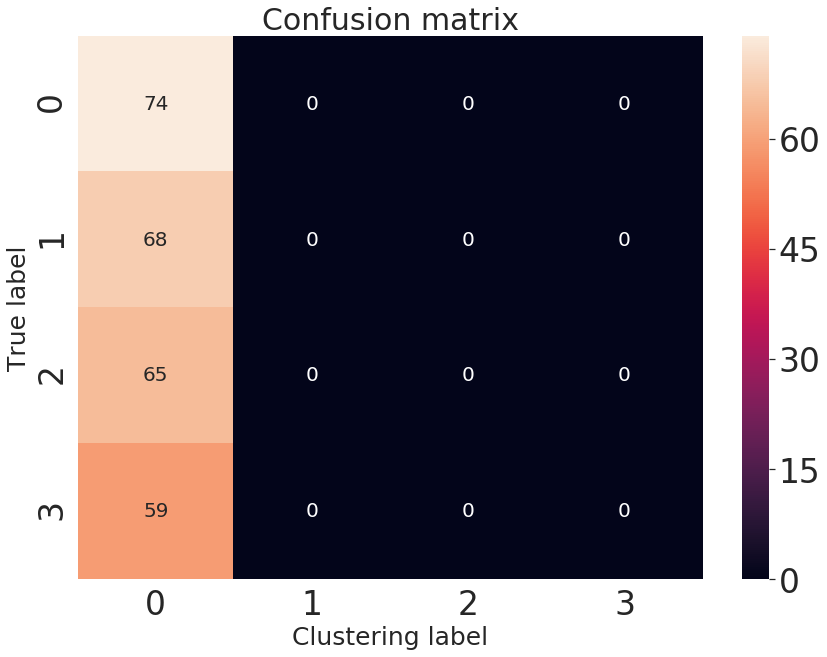

In [305]:
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [310]:
def vis_data(x_train_encoded, y_train, vis_dim, n_predict, n_train, build_anim):
    cmap = plt.get_cmap('rainbow', 10)

    # 3-dim vis: show one view, then compile animated .gif of many angled views
    if vis_dim == 3:
        # Simple static figure
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                c=y_train[:n_predict], cmap=cmap, edgecolor='black')
        fig.colorbar(p, drawedges=True)
        plt.show()

        # Build animation from many static figures
        if build_anim:
            angles = np.linspace(180, 360, 20)
            i = 0
            for angle in angles:
                fig = plt.figure()
                ax = plt.axes(projection='3d')
                ax.view_init(10, angle)
                p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                        c=y_train[:n_predict], cmap=cmap, edgecolor='black')
                fig.colorbar(p, drawedges=True)
                outfile = 'anim/3dplot_step_' + chr(i + 97) + '.png'
                plt.savefig(outfile, dpi=96)
                i += 1
            call(['convert', '-delay', '50', 'anim/3dplot*', 'anim/3dplot_anim_' + str(n_train) + '.gif'])

    # 2-dim vis: plot and colorbar.
    elif vis_dim == 2:
        plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], 
                c=y_train[:n_predict], edgecolor='black', cmap=cmap)
        plt.colorbar(drawedges=True)
        plt.show()

In [319]:
# Encode a number of MNIST digits, then perform t-SNE dim-reduction.
x_train_predict = encoder.predict(x)

#print "Performing t-SNE dimensionality reduction..."
x_train_encoded = TSNE(n_components=2).fit_transform(x_train_predict)
#np.save('%sx_%sdim_tnse_%s.npy' % (266, 2, 266), x_train_encoded)
#x_train_encoded = np.load(str(n_predict) + 'x_' + str(vis_dim) + 'dim_tnse_' + str(n_train) + '.npy')


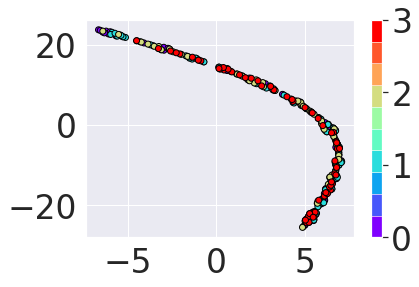

In [324]:
# Visualize result.
train_new = False
n_train = 2660
predict_new = False
n_predict = 2660
vis_dim = 2
build_anim = False
    
vis_data(x_train_encoded, y, vis_dim, n_predict, n_train, build_anim)

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives


def create_lstm_autoencoder(input_dim, timesteps, latent_dim):
    """
    Creates an LSTM Autoencoder (VAE). Returns Autoencoder, Encoder, Generator. 
    (All code by fchollet - see reference.)
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        latent_dim: int, latent z-layer shape. 
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
    """

    inputs = Input(shape=(timesteps, input_dim,))
    encoded = LSTM(latent_dim)(inputs)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True)(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder